In [19]:
# Cell 1: Imports & Environment Setup
import os
import time
import numpy as np
import pandas as pd
import torch
import pandapower as pp
import pandapower.networks as pn
import matplotlib.pyplot as plt
import seaborn as sns

# 检查 Numba 加速状态 (Pandapower 的性能核心)
try:
    import numba
    print(f"✅ Numba detected (v{numba.__version__}). Power flow calculation will be fast.")
except ImportError:
    print("⚠️ Numba not found. Simulation will be slow. Please install it via 'pip install numba'.")

# 设置全局随机种子 (Reproducibility)
SEED = 2025
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"Current Working Directory: {os.getcwd()}")

✅ Numba detected (v0.63.1). Power flow calculation will be fast.
Current Working Directory: c:\Users\10856\Desktop\GithubProject\lvdn-diff\notebooks


In [20]:
# Cell 2: Global Configuration Constants

# --- 仿真规模 ---
TARGET_SAMPLES = 50000        # 目标样本数
STEPS_PER_DAY = 96            # 时间分辨率 (15min)
N_DAYS = int(TARGET_SAMPLES / STEPS_PER_DAY) + 1  # 需要模拟的天数 (约521天)

# --- 电网物理参数 (Stress Test Settings) ---
SLACK_BUS_VM_PU = 1.025       # 变压器首端电压 (抬高以促成过压)
PF_LOAD = 0.95                # 负荷功率因数
PF_PV = 1.0                   # 光伏功率因数

# --- 容量设定 (Hard Reset) ---
# 既然默认值太小，我们手动赋予物理意义
LOAD_CAPACITY_MIN = 0.005     # 单户最小负荷容量 (5 kW)
LOAD_CAPACITY_MAX = 0.015     # 单户最大负荷容量 (15 kW)

PV_CAPACITY_MIN = 0.020       # 单户最小光伏装机 (20 kW)
PV_CAPACITY_MAX = 0.050       # 单户最大光伏装机 (50 kW)

# --- 渗透率设定 ---
PV_PENETRATION_RATE = 0.70    # 70% 的用户安装光伏
EV_PENETRATION_RATE = 0.30    # 30% 的用户有电动汽车
EV_CHARGING_POWER = 0.022     # EV 快充功率 (22 kW)

# --- 路径配置 ---
SAVE_DIR = os.path.join("..", "data", "processed")
FILENAME = "cigre_lv_stress_test_v1.pt"

In [21]:
# Cell 3: Profile Generator Helper Functions

def get_daily_h0_profile(n_steps=96):
    """
    生成标准化的居民负荷曲线 (H0 Profile based)
    特征：早晚双峰，含随机噪声。
    """
    t = np.linspace(0, 24, n_steps)
    base = 0.1
    morning_peak = 0.4 * np.exp(-(t - 8)**2 / 2)
    evening_peak = 0.8 * np.exp(-(t - 19)**2 / 4)
    
    profile = base + morning_peak + evening_peak
    # 添加高频抖动 (Grid noise)
    profile += np.random.normal(0, 0.02, n_steps)
    return np.clip(profile, 0.05, 1.5)

def get_daily_pv_profile(n_steps=96, cloud_cover=0.0):
    """
    生成标准化的光伏出力曲线
    特征：钟形曲线，受云层遮挡影响。
    """
    t = np.linspace(0, 24, n_steps)
    # 理想日照几何
    pv_potential = np.maximum(0, np.sin((t - 6) * np.pi / 12))
    pv_potential[t < 6] = 0
    pv_potential[t > 18] = 0
    
    # 模拟云层遮挡 (乘法噪声)
    if cloud_cover > 0:
        # Beta分布能产生比较自然的云层遮挡效果
        clouds = 1 - np.random.beta(2, 5, n_steps) * cloud_cover
        pv_potential *= clouds
        
    return pv_potential

In [22]:
# Cell 4: The Stress Test Data Generator

def generate_synthetic_dataset(n_days):
    """
    生成大规模 CIGRE LV 压力测试数据集。
    包含：电压越限、反向潮流、EV 冲击场景。
    """
    # 1. 初始化网络与拓扑
    net = pn.create_cigre_network_lv()
    net.ext_grid['vm_pu'] = SLACK_BUS_VM_PU # 策略1: 抬高首端电压
    
    n_loads = len(net.load)
    
    # 2. 暴力重置容量 (Hard Reset Capacities)
    # 忽略 Pandapower 默认的微小负荷，赋予真实的物理容量
    nominal_load_mw = np.random.uniform(LOAD_CAPACITY_MIN, LOAD_CAPACITY_MAX, n_loads)
    
    # 3. 配置光伏节点 (PV Allocation)
    pv_indices = np.random.choice(n_loads, size=int(n_loads * PV_PENETRATION_RATE), replace=False)
    nominal_pv_mw = np.zeros(n_loads)
    nominal_pv_mw[pv_indices] = np.random.uniform(PV_CAPACITY_MIN, PV_CAPACITY_MAX, len(pv_indices))
    
    # 4. 配置电动汽车节点 (EV Allocation)
    ev_indices = np.random.choice(n_loads, size=int(n_loads * EV_PENETRATION_RATE), replace=False)

    print(f"🚀 Starting Generation for {n_days} days...")
    print(f"   Nodes: {n_loads}, PV Nodes: {len(pv_indices)}, EV Nodes: {len(ev_indices)}")
    print(f"   Total PV Capacity: {nominal_pv_mw.sum():.2f} MW (Strong Backflow Expected)")

    # 容器初始化
    X_list = []    # Input: [P_tot, Q_tot, Time]
    Y_v_list = []  # Label: [V_nodes]
    Y_p_list = []  # Label: [P_nodes]
    
    start_time = time.time()
    total_samples = 0
    
    # --- 主循环: 天 ---
    for day in range(n_days):
        # 每日随机环境因子
        season_factor = np.random.uniform(0.7, 1.3) # 季节性负荷波动
        daily_cloud = np.random.uniform(0.0, 0.6)   # 天气 (倾向于晴天以制造过压)
        
        # 获取当日基础曲线
        h0_curve = get_daily_h0_profile(STEPS_PER_DAY)
        pv_curve = get_daily_pv_profile(STEPS_PER_DAY, cloud_cover=daily_cloud)
        
        # 每日随机生成 EV 充电计划 (晚上 17:00 - 20:00 开始)
        ev_start_times = np.random.randint(68, 80, len(ev_indices)) 
        
        # --- 子循环: 时刻 ---
        for step in range(STEPS_PER_DAY):
            # A. 计算基础负荷 (Base Load)
            # 加入个体差异 (Individual Fluctuation)
            individual_noise = np.random.normal(1.0, 0.1, n_loads)
            p_load_inst = nominal_load_mw * season_factor * h0_curve[step] * individual_noise
            
            # B. 叠加 EV 充电负荷 (EV Charging)
            # 假设充电持续 16 个时间步 (4小时)
            for i, ev_idx in enumerate(ev_indices):
                if ev_start_times[i] <= step < ev_start_times[i] + 16:
                    p_load_inst[ev_idx] += EV_CHARGING_POWER

            # C. 计算光伏出力 (PV Generation)
            p_pv_inst = nominal_pv_mw * pv_curve[step] * np.random.normal(1.0, 0.1, n_loads)
            
            # D. 计算净注入 (Net Injection)
            p_net = p_load_inst - p_pv_inst
            # 简化的无功计算 Q = P * tan(acos(pf))
            # 负荷消耗 Q, 光伏通常设为单位功率因数(Q=0)或者少量 Q
            q_net = p_load_inst * np.tan(np.arccos(PF_LOAD)) 
            
            # E. 写入网络并计算潮流
            net.load['p_mw'] = p_net
            net.load['q_mvar'] = q_net
            
            try:
                pp.runpp(net)
                
                # F. 收集数据
                # Input: 首端 P, Q (注意方向：Ext_grid 正值代表从电网买电，负值代表倒送)
                p_tot = net.res_ext_grid['p_mw'].values[0]
                q_tot = net.res_ext_grid['q_mvar'].values[0]
                time_feat = step / STEPS_PER_DAY
                
                # Output: 全网节点电压
                v_nodes = net.res_bus['vm_pu'].values
                
                X_list.append([p_tot, q_tot, time_feat])
                Y_v_list.append(v_nodes.copy())
                Y_p_list.append(p_net.copy())
                
                total_samples += 1
                
            except pp.LoadflowNotConverged:
                # 极端情况下可能不收敛，直接跳过，不影响整体
                continue
        
        # 进度打印
        if (day + 1) % 50 == 0:
            elapsed = time.time() - start_time
            speed = total_samples / elapsed
            print(f"   [Progress] Day {day+1}/{n_days} | Samples: {total_samples} | Speed: {speed:.1f} it/s")

    print(f"✅ Generation Complete. Total valid samples: {len(X_list)}")
    
    return np.array(X_list), np.array(Y_v_list), np.array(Y_p_list)

🚀 Starting Generation for 521 days...
   Nodes: 15, PV Nodes: 10, EV Nodes: 4
   Total PV Capacity: 0.33 MW (Strong Backflow Expected)
   [Progress] Day 50/521 | Samples: 4800 | Speed: 81.7 it/s
   [Progress] Day 100/521 | Samples: 9600 | Speed: 83.6 it/s
   [Progress] Day 150/521 | Samples: 14400 | Speed: 83.4 it/s
   [Progress] Day 200/521 | Samples: 19200 | Speed: 82.7 it/s
   [Progress] Day 250/521 | Samples: 24000 | Speed: 81.5 it/s
   [Progress] Day 300/521 | Samples: 28800 | Speed: 81.8 it/s
   [Progress] Day 350/521 | Samples: 33600 | Speed: 82.0 it/s
   [Progress] Day 400/521 | Samples: 38400 | Speed: 81.3 it/s
   [Progress] Day 450/521 | Samples: 43200 | Speed: 81.4 it/s
   [Progress] Day 500/521 | Samples: 48000 | Speed: 81.3 it/s
✅ Generation Complete. Total valid samples: 50016

📊 Dataset Statistics:
X Shape: (50016, 3)
Y_v Shape: (50016, 44)
Overvoltage Samples (>1.05): 16877 (33.74%)
Undervoltage Samples (<0.95): 1358 (2.72%)
Transformer Max Reverse Power: -0.3292 MW
Tra

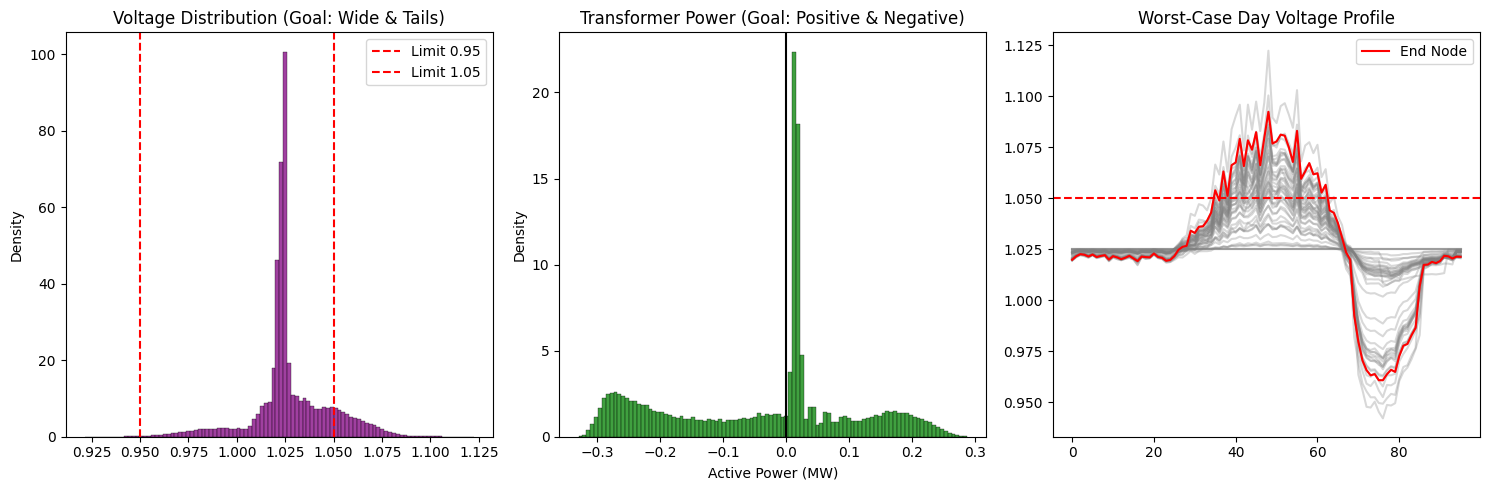

In [23]:
# Cell 5: Execute Generation & Verify Distributions

# 1. 运行生成
X_raw, Y_v_raw, Y_p_raw = generate_synthetic_dataset(n_days=N_DAYS)

# 2. 验证统计量 (Sanity Check)
print("\n📊 Dataset Statistics:")
print(f"X Shape: {X_raw.shape}")
print(f"Y_v Shape: {Y_v_raw.shape}")

# 越限统计
n_total = len(Y_v_raw)
n_high = np.sum(np.any(Y_v_raw > 1.05, axis=1))
n_low = np.sum(np.any(Y_v_raw < 0.95, axis=1))

print(f"Overvoltage Samples (>1.05): {n_high} ({n_high/n_total*100:.2f}%)")
print(f"Undervoltage Samples (<0.95): {n_low} ({n_low/n_total*100:.2f}%)")
print(f"Transformer Max Reverse Power: {X_raw[:, 0].min():.4f} MW")
print(f"Transformer Max Peak Load:     {X_raw[:, 0].max():.4f} MW")

# 3. 绘图检查
plt.figure(figsize=(15, 5))

# 图1: 电压分布 (核心指标)
plt.subplot(1, 3, 1)
sns.histplot(Y_v_raw.flatten(), bins=100, color='purple', stat='density')
plt.axvline(0.95, color='r', linestyle='--', label='Limit 0.95')
plt.axvline(1.05, color='r', linestyle='--', label='Limit 1.05')
plt.title("Voltage Distribution (Goal: Wide & Tails)")
plt.legend()

# 图2: 变压器功率分布 (核心指标)
plt.subplot(1, 3, 2)
sns.histplot(X_raw[:, 0], bins=100, color='green', stat='density')
plt.axvline(0, color='k', linestyle='-')
plt.title("Transformer Power (Goal: Positive & Negative)")
plt.xlabel("Active Power (MW)")

# 图3: 最差样本日曲线 (Stress Test Profile)
plt.subplot(1, 3, 3)
# 找到电压最高的那一天
max_v_idx = np.argmax(np.max(Y_v_raw, axis=1))
day_start = (max_v_idx // STEPS_PER_DAY) * STEPS_PER_DAY
day_profile = Y_v_raw[day_start : day_start + STEPS_PER_DAY]

plt.plot(day_profile, color='gray', alpha=0.3)
plt.plot(day_profile[:, -1], color='red', label='End Node') # 假设最后一个是末端
plt.axhline(1.05, color='r', linestyle='--')
plt.title("Worst-Case Day Voltage Profile")
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Cell 6: Save Data to Disk

# 1. 创建目录
os.makedirs(SAVE_DIR, exist_ok=True)
save_path = os.path.join(SAVE_DIR, FILENAME)

# 2. 转换为 PyTorch Tensor (Float32 以节省显存)
print("Converting to PyTorch Tensors...")
data_bundle = {
    "X": torch.from_numpy(X_raw).float(),   # [N, 3]
    "Y_v": torch.from_numpy(Y_v_raw).float(), # [N, Buses]
    "Y_p": torch.from_numpy(Y_p_raw).float(), # [N, Buses]
    "metadata": {
        "description": "CIGRE LV Stress Test Dataset (High PV/EV)",
        "config": {
            "n_days": N_DAYS,
            "slack_vm": SLACK_BUS_VM_PU,
            "pv_penetration": PV_PENETRATION_RATE,
            "ev_penetration": EV_PENETRATION_RATE
        }
    }
}

# 3. 保存
torch.save(data_bundle, save_path)
print(f"✅ Data successfully saved to: {os.path.abspath(save_path)}")
print(f"   Filesize: {os.path.getsize(save_path) / 1024 / 1024:.2f} MB")

Converting to PyTorch Tensors...
✅ Data successfully saved to: c:\Users\10856\Desktop\GithubProject\lvdn-diff\data\processed\cigre_lv_stress_test_v1.pt
   Filesize: 11.83 MB
